In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from gromo.tools import *
import tensorly as tl
tl.set_backend('pytorch')

In [2]:
def assert_close(a, b, msg="", atol=1e-8, rtol=1e-5):
    assert a.shape == b.shape, f"{msg} (shape mismatch : {a.shape} != {b.shape})"
    assert torch.allclose(a, b, atol=atol, rtol=rtol), f"{msg} (||.||_inf = {torch.max(torch.abs(a - b)):2e}, ||.||_0 = {torch.sum(torch.abs(a - b) > 1e-6) / a.numel():2e} %, ||.||_2 = {torch.norm(a - b) / torch.norm(b):2e})"


def torch_scalar_product(a, b):
    assert a.shape == b.shape, f"shape mismatch : {a.shape} != {b.shape}"
    assert_close(torch.sum(a * b), torch.trace(a.T @ b), atol=1e-6, msg="torch_scalar_product")
    return torch.trace(a.T @ b)

# Lemma

Conv o AvgPool = AvgPool o Conv

In [3]:
# Hyperparameters
cin = 4
cout = 5
ĥd = 3
wd = 2
h = 22
w = 31
px = 5
py = 6
n = 10

# Create a random image
x = torch.randn(n, cin, h, w)

# Create the layers
conv = nn.Conv2d(cin, cout, wd)
pool = nn.AvgPool2d((px, py), stride=(1, 1))

# Forward pass
y1 = conv(pool(x))
y2 = pool(conv(x))

# Check the shapes
assert y1.shape == y2.shape, f"Shapes are different: {y1.shape=} != {y2.shape=}"

assert_close(y1, y2, "There is no commutativity", atol=1e-6)

# Conv to conv

## Define the data

In [ ]:
# Hyperparameters
c0 = 5
c1 = 6
c2 = 7

hd1 = 3
wd1 = 5
hd2 = 5
wd2 = 3

h0 = 9
w0 = 10

# h0 = 21
# w0 = 30

n = 2

# Create a random image

x = torch.randn(n, c0, h0, w0)
pre_conv = nn.Conv2d(c0, c0, (3, 3), padding=1, bias=False)
x = pre_conv(x) # add unisotropicity

# Create the layers
conv1 = nn.Conv2d(c0, c1, (hd1, wd1), bias=False)
assert conv1.weight.shape == (c1, c0, hd1, wd1), f"Wrong shape: {conv1.weight.shape=}"
conv2 = nn.Conv2d(c1, c2, (hd2, wd2), bias=False)

conv_natural_gradient = nn.Conv2d(c1, c2, (hd2, wd2), bias=False)

# Forward pass
print(f"Start with {x.shape=}")
print(f"Apply {conv1=} (output shape: {conv1(x).shape})")
print(f"Apply {conv2=} (output shape: {conv2(conv1(x)).shape})")

h1, w1 = conv1(x).shape[-2:]
h2, w2 = conv2(conv1(x)).shape[-2:]

y_inter_th = conv1(x)
y_th = conv2(conv1(x))

y_goal = torch.rand_like(y_th)
y_goal_inter = torch.rand_like(y_inter_th)

error_th = torch.sum((y_goal - y_th) ** 2)

In [5]:
def assert_shape(tensor: torch.Tensor, shape: str) -> None:
    shape_def = {
        "n": n,
        "dh": hd1,
        "dh[+1]": hd2,
        "dw": wd1,
        "dw[+1]": wd2,
        "h": h1,
        "h[+1]": h2,
        "w": w1,
        "w[+1]": w2,
        "c[-1]": c0,
        "c": c1, 
        "c[+1]": c2,
        }
    txt = shape.lower().split(",")
    assert len(tensor.shape) == len(txt), f"Order mismatch : (real) {len(tensor.shape)} != {len(txt)} (theory)"
    for i, (real, theory) in enumerate(zip(tensor.shape, txt)):
        theory = theory.strip()
        theory = theory.replace("  ", " ") 
        products = theory.split(" ")
        theory_value = 1
        for prod in products:
            if prod in shape_def:
                theory_value *= shape_def[prod]
            else:
                raise ValueError(f"Unknown symbol {prod}")
        assert real == theory_value, f"Shape mismatch on index {i} : {theory} is not matching {real}"

## First Convolution

In [6]:
y_goal_flat = y_goal.flatten(start_dim=-2)
assert_shape(y_goal_flat, "n, C[+1], H[+1] W[+1]")

y_goal_mat = y_goal_flat.permute(0, 2, 1).flatten(end_dim=1)
assert_shape(y_goal_mat, "n H[+1] W[+1], C[+1]")

$V_F \in (n H[+1] W[+1], C[+1])$

In [7]:
theta_2_flat = conv2.weight.view(c2, -1)
assert_shape(theta_2_flat, "C[+1], C dh[+1] dw[+1]")

$dW_F \in (C[+1], C d[+1] d[+1])$

In [8]:
bc_inter = torch.nn.functional.unfold(y_inter_th, (hd2, wd2), padding=conv2.padding, stride=conv2.stride, dilation=conv2.dilation)
assert_shape(bc_inter, "n, C dh[+1] dw[+1], H[+1] W[+1]")

bc_inter_flat = bc_inter.permute(0, 2, 1).flatten(end_dim=1)
assert_shape(bc_inter_flat, "n H[+1] W[+1], C dh[+1] dw[+1]")

$B^c \in (n, C d[+1] d[+1], H[+1]W[+1])$

$B^c_F \in (n H[+1]W[+1], C d[+1] d[+1])$

In [9]:
y_inter_matmul_paper = bc_inter_flat @ theta_2_flat.T
assert_shape(y_inter_matmul_paper, "n H[+1] W[+1], C[+1]")

assert_close(y_inter_matmul_paper.reshape(n, h2, w2, c2).permute(0, 3, 1, 2), y_th, atol=1e-6)

$Conv_{dW}(B) \equiv B^c_F dW_F^T$

In [10]:
y_inter_manual_einsum = torch.einsum("iam, ca -> icm", bc_inter, theta_2_flat).reshape(n, c2, h2, w2)
y_inter_manual_matmul = (bc_inter.permute(0, 2, 1) @ theta_2_flat.T).permute(0, 2, 1).reshape(n, c2, h2, w2)
y_inter_manual_mode_dot = tl.tenalg.mode_dot(bc_inter, theta_2_flat, mode=1).reshape(n, c2, h2, w2)

assert_close(y_inter_manual_einsum, y_th, atol=1e-6)
assert_close(y_inter_manual_matmul, y_th, atol=1e-7)
assert_close(y_inter_manual_mode_dot, y_th, atol=1e-7)

$Conv_{\Theta_1}(B) \equiv (B^c)^{iam} \Theta_1^{ca} = (B^c) \times_1 \Theta_1 \equiv (B^c_F) \times \Theta_1^T$

### Optimal update

In [11]:
s_inter_paper = bc_inter_flat.T @ bc_inter_flat
assert_shape(s_inter_paper, "C dh[+1] dw[+1], C dh[+1] dw[+1]")

m_inter_paper = bc_inter_flat.T @ y_goal_mat
assert_shape(m_inter_paper, "C dh[+1] dw[+1], C[+1]")

$S := (B^c_F)^T B^c_F \in (C d[+1]d[+1], C d[+1]d[+1])$

$M := (B^c_F)^T V_F \in (C d[+1]d[+1], C[+1])$

In [12]:
s_inter_einsum = torch.einsum("iam, ibm -> ab", bc_inter, bc_inter)
assert_close(s_inter_einsum, s_inter_paper, atol=1e-6)

m_inter_einsum = torch.einsum("iam, icm -> ac", bc_inter, y_goal_flat)
assert_close(m_inter_einsum, m_inter_paper, atol=1e-6)

In [13]:
delta_star = torch.linalg.solve(s_inter_paper, m_inter_paper).T
assert_shape(delta_star, "C[+1], C dh[+1] dw[+1]")

## Double Convolution

In [14]:
bc = torch.nn.functional.unfold(x, (hd1, wd1), padding=conv1.padding, stride=conv1.stride, dilation=conv1.dilation)
assert_shape(bc, "n, C[-1] dh dw, H W")

bc_flat = bc.permute(0, 2, 1).flatten(end_dim=1)
assert_shape(bc_flat, "n H W, C[-1] dh dw")

$B^c \in (n, C[-1] d d, HW)$

$B^c_F \in (n HW, C[-1] d d)$

In [15]:
t = compute_mask_tensor_t((h1, w1), conv2)
assert_shape(t, "H[+1] W[+1], dh[+1] dw[+1], H W")

tt = torch.einsum("mbl, mdk -> bldk", t, t)
assert_shape(tt, "dh[+1] dw[+1], H W, dh[+1] dw[+1], H W")

$T \in (H[+1]W[+1], d[+1]d[+1], HW)$

$(TT)^{bldk} = T^{mbl} T_{mdk} \in (d[+1]d[+1], HW, d[+1]d[+1], HW)$

In [16]:
bt_einsum = torch.einsum("ial, jel -> ijea", bc, t)

bt_manual = torch.zeros((n, h2 * w2, hd2 * wd2, c0 * hd1 * wd1))
for i in range(n):
    for j in range(h2 * w2):
        bt_manual[i, j] = t[j] @ bc[i].detach().T

assert_close(bt_einsum, bt_manual, atol=1e-6)
bt = bt_einsum

assert_shape(bt, "n, H[+1] W[+1], dh[+1] dw[+1], C[-1] dh dw")

$(B^t)^{imba} = (B^c)^{ial} T_{mbl} \in (n, H[+1]W[+1], d[+1]d[+1], C[-1]dd)$

$(B^t)[i, j] =  T[j] \times (B^c)[i]^T \in (d[+1]d[+1], C[-1]dd)$

In [17]:
y_manual = torch.zeros((n, c2, h2 * w2))

alpha_flat = conv1.weight.flatten(start_dim=1).transpose(0, 1)
assert alpha_flat.shape == (c0 * hd1 * wd1, c1)

omega_flat = conv2.weight.flatten(start_dim=2)
assert omega_flat.shape == (c2, c1, hd2 * wd2)

for i in range(n):
    for m in range(c2):
        for j in range(h2 * w2):
            for k in range(c1):
                # equivalent to omega_flat[m, k].T @ bt[i, j] @ alpha_flat[:, k].T
                # as omega_flat[m, k] and alpha_flat[:, k] are vectors in the paper
                y_manual[i, m, j] += omega_flat[m, k] @ bt[i, j] @ alpha_flat[:, k]

assert_close(y_manual, y_th.flatten(start_dim=-2), atol=1e-6)

y_manual_einsum = torch.einsum("mke, ijea, ak -> imj", omega_flat, bt, alpha_flat)

assert_close(y_manual_einsum, y_th.flatten(start_dim=-2), atol=1e-6)

assert omega_flat.shape == (c2, c1, hd2 * wd2)  # m k e
assert t.shape == (h2 * w2, hd2 * wd2, h1 * w1)  # i a l
assert bc.shape == (n, c0 * hd1 * wd1, h1 * w1)  # j e l
assert alpha_flat.shape == (c0 * hd1 * wd1, c1)  # a k

y_manual_full_einsum = torch.einsum("mke, jel, ial, ak -> imj", omega_flat, t, bc, alpha_flat)

assert_close(y_th.flatten(start_dim=-2), y_manual_full_einsum, atol=1e-6)

$Conv_{\Omega}(Conv_{\Alpha}(B))[i, m, j] = \sum_{k=1}^{C} \Omega[m, k]_F^T (B^t)[i, j]^T A[k]_F$ 

$Conv_{\Omega}(Conv_{\Alpha}(B))^{i  m j} = \Omega^{m k e} (B^t)^{i j e a} A_F^{a k}$

$Conv_{\Omega}(Conv_{\Alpha}(B))^{i  m j} = \Omega^{m k e} T^{j e l} (B^c)^{i a l} A_F^{a k}$

### Proof checking

#### Scalar product

In [18]:
assert y_goal_flat.shape == (n, c2, h2 * w2)


l_value_th = torch.sum(y_goal.flatten() * y_th.flatten())
l_value_th_einsum = torch.einsum("imxy, imxy ->", y_goal, y_th)
assert_close(l_value_th, l_value_th_einsum, atol=1e-6)

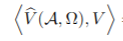

In [19]:
l_value = torch.tensor(0.)

for m in range(c2):
    for i in range(n):
        for j in range(h2 * w2):
            for k in range(c1):
                l_value += omega_flat[m, k] @ bt[i, j] @ alpha_flat[:, k] * y_goal_flat[i, m, j]


assert_close(l_value, l_value_th, atol=1e-6)

l_value_einsum = torch.einsum("imj, mke, ijea, ak ->", y_goal_flat, omega_flat, bt, alpha_flat)
assert_close(l_value_einsum, l_value_th, atol=1e-6)

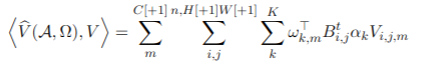

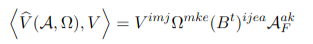

In [20]:
omega_full_flat = omega_flat.permute(1, 0, 2).flatten(start_dim=1)
assert omega_full_flat.shape == (c1, c2 * hd2 * wd2)

alpha_omega = alpha_flat @ omega_full_flat
assert alpha_omega.shape == (c0 * hd1 * wd1, c2 * hd2 * wd2)

In [21]:
assert bt.shape == (n, h2 * w2, hd2 * wd2, c0 * hd1 * wd1)
assert y_goal_flat.shape == (n, c2, h2 * w2)

tensor_m = torch.einsum("ixab, icx -> bca", bt, y_goal_flat)
assert tensor_m.shape == (c0 * hd1 * wd1, c2, hd2 * wd2)

m_matrice = tensor_m.flatten(start_dim=1)
assert m_matrice.shape == (c0 * hd1 * wd1, c2 * hd2 * wd2)

m_paper = torch.zeros((c0 * hd1 * wd1, c2 * hd2 * wd2))
for c in range(c2):
    idx = c * hd2 * wd2
    for i in range(n):
        for j in range(h2 * w2):
            m_paper[:, idx:idx + hd2 * wd2] += y_goal_flat[i, c, j] * bt[i, j].T

assert_close(m_matrice, m_paper, atol=1e-6) 

l_paper_end = torch_scalar_product(alpha_omega, m_matrice)

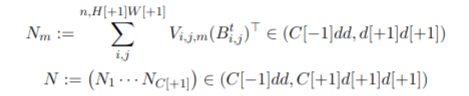

$\langle \hat{V}(A, \Omega), V \rangle = \langle A_F \Omega_F, N \rangle$

#### Scalar product

In [22]:
q_value_th = torch.sum(y_th ** 2)

q_value = torch.tensor(0.)

for m in range(c2):
    for i in range(n):
        for j in range(h2 * w2):
            q = torch.tensor(0.)
            for k in range(c1):
                q += omega_flat[m, k] @ bt[i, j] @ alpha_flat[:, k]
            q_value += q ** 2

assert_close(q_value, q_value_th, atol=1e-6)

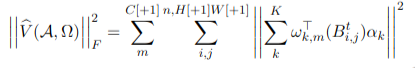

In [23]:
q_value_tr = torch.tensor(0.)

for m in range(c2):
    w = alpha_flat @ omega_flat[m]
    assert w.shape == (c0 * hd1 * wd1, hd2 * wd2)
    for i in range(n):
        for j in range(h2 * w2):
            q_value_tr += torch.trace(bt[i, j] @ w) ** 2

assert_close(q_value_tr, q_value_th, atol=1e-6)

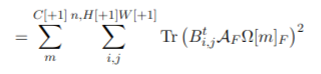

In [24]:
s_paper = torch.zeros((c0 * hd1 * wd1, c0 * hd1 * wd1), dtype=torch.float64)

mul_facteur = hd2 * wd2
# mul_facteur = c1

for i in range(n):
    for j in range(h2 * w2):
        s_paper += bt[i, j].T @ bt[i, j]



s_paper *= mul_facteur


bt64 = bt.to(torch.float64)
s_einsum = mul_facteur * torch.einsum("ijea, ijeb -> ab", bt64, bt64)

assert_close(s_einsum, s_paper, atol=1e-4)
s = s_einsum.to(torch.float32)

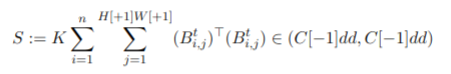

In [ ]:
q_maj = torch_scalar_product(alpha_omega, s @ alpha_omega)

assert q_maj >= q_value_th

f"Qmax / Q = {q_maj / q_value_th:.3e} (Qmax = {q_maj.item(): .3e}, Q = {q_value_th.item(): .3e})"

### One pass

In [26]:
y_goal_proj_th = y_goal - conv_natural_gradient(y_inter_th)
y_goal_proj_th_flat = y_goal_proj_th.flatten(start_dim=-2)
assert_shape(y_goal_proj_th_flat, "n, C[+1], H[+1] W[+1]")

assert_shape(bt, "n, H[+1] W[+1], dh[+1] dw[+1], C[-1] dh dw")

m_proj_th = torch.einsum("ixab, icx -> bca", bt, y_goal_proj_th_flat)
assert_shape(m_proj_th, "C[-1] dh dw, C[+1], dh[+1] dw[+1]")

In [27]:
dw_star_th = conv_natural_gradient.weight.flatten(start_dim=2) 
assert_shape(dw_star_th, "C[+1], C, dh[+1] dw[+1]")
dw_star_th_mat = dw_star_th.flatten(start_dim=1)
assert_shape(dw_star_th_mat, "C[+1], C dh[+1] dw[+1]")

In [28]:
assert_shape(y_goal_flat, "n, C[+1], H[+1] W[+1]")
assert_shape(bc_inter, "n, C dh[+1] dw[+1], H[+1] W[+1]")
y_goal_proj_einsum = y_goal_flat - torch.einsum("iex, ce -> icx", bc_inter, dw_star_th_mat)
assert_shape(y_goal_proj_einsum, "n, C[+1], H[+1] W[+1]")

In [29]:
mm2 = torch.einsum("ixab, icx -> bca", bt, y_goal_flat)
assert_shape(mm2, "C[-1] dh dw, C[+1], dh[+1] dw[+1]")

In [30]:
assert_shape(bt, "n, H[+1] W[+1], dh[+1] dw[+1], C[-1] dh dw")
assert_shape(bc_inter, "n, C dh[+1] dw[+1], H[+1] W[+1]")

tensor_c = torch.einsum("ixab, iex -> abe", bt, bc_inter)
assert_shape(tensor_c, "dh[+1] dw[+1], C[-1] dh dw, C dh[+1] dw[+1]")

In [31]:
neg_term = torch.einsum("abe, ce -> bca", tensor_c, dw_star_th_mat)
assert_shape(neg_term, "C[-1] dh dw, C[+1], dh[+1] dw[+1]")

In [32]:
assert_shape(neg_term, "C[-1] dh dw, C[+1], dh[+1] dw[+1]")
assert_shape(mm2, "C[-1] dh dw, C[+1], dh[+1] dw[+1]")
m_proj = mm2 - neg_term
assert_shape(m_proj, "C[-1] dh dw, C[+1], dh[+1] dw[+1]")
assert_close(m_proj, m_proj_th, atol=1e-6)

### Calcul exact

In [47]:
alpha_omega = torch.einsum("ka, mke -> mea", alpha_flat, omega_flat)
assert alpha_omega.shape == (c2, hd2 * wd2, c0 * hd1 * wd1)

alpha_omega_matrice = alpha_omega.flatten(end_dim=1)
assert alpha_omega_matrice.shape == (c2 * hd2 * wd2, c0 * hd1 * wd1)

alpha_omega_matrice_exact = alpha_omega.flatten(start_dim=1)
assert alpha_omega_matrice_exact.shape == (c2, hd2 * wd2 * c0 * hd1 * wd1)

In [29]:
m_matrice_exact = tensor_m.flatten(start_dim=1)
assert m_matrice_exact.shape == (c2, hd2 * wd2 * c0 * hd1 * wd1)

In [48]:
l_value_scalar = torch.sum(m * alpha_omega)

l_value_mat = torch.trace(m_matrice @ alpha_omega_matrice.T)

l_value_exact = torch.trace(m_matrice_exact @ alpha_omega_matrice_exact.T)

assert_close(l_value_mat, l_value_th, atol=1e-6)
assert_close(l_value_exact, l_value_th, atol=1e-6)
assert_close(l_value_scalar, l_value_th, atol=1e-6)

In [15]:
assert_close(q_value - 2 * l_value + torch.sum((y_goal) ** 2), error_th, atol=1e-6)

In [49]:
assert bt.shape == (n, h2 * w2, hd2 * wd2, c0 * hd1 * wd1)
s = torch.einsum("ijea, ijfb -> eafb", bt, bt)
assert s.shape == (hd2 * wd2, c0 * hd1 * wd1, hd2 * wd2, c0 * hd1 * wd1)

In [45]:
q_value_scalar = torch.einsum("mea, eafb, mfb ->", alpha_omega, s, alpha_omega)

assert_close(q_value_scalar, q_value_th, atol=1e-6)

In [50]:
s_matrice_exact = s.flatten(start_dim=2).flatten(end_dim=1)
assert s_matrice_exact.shape == (hd2 * wd2 * c0 * hd1 * wd1, hd2 * wd2 * c0 * hd1 * wd1)

In [52]:
q_value_exact = torch.trace(alpha_omega_matrice_exact @ s_matrice_exact @ alpha_omega_matrice_exact.T)

assert_close(q_value_exact, q_value_th, atol=1e-6)